# Sylvester Flows 
Let $z\in \mathbb{R}^d, A (d\times m), B (m\times d), c \in \mathbb{R}^m$, and $h:\mathbb{R}\to\mathbb{R}$ an activation function that we ambiguously apply to vectors componentwise.   
Define a Sylvester flow as 
$$f(z) = z + A h(Bz + c)$$ 
and note that 
$$J_f = f'(z) = I_d + A_{d \times m} diag(h'(Bz+c))_{m \times m} B_{m \times d}.$$ 

Need to take determinant of this. 

### Sylvester's theorm AKA Weinstein–Aronszajn identity states that 
$$\det (I_d + A_{d \times m} B_{m \times d}) = \det (I_m + B_{m \times d} A_{d \times m})$$ 
hence when $m< d$, we can compute this determinant in the lower dimensional representation!


### Special Case: $A = QR, B = \hat{R} Q^t$ 
We consider the special case where $A = Q_{d\times d}R_{d\times m}, B = \hat{R}_{m\times d}Q^t_{d\times d}$ with $Q$ unitary $R, \hat{R}$ upper triangular. Note that any matrix can be written as a QR decomposition, so the restriction here is simply that it is the same Q defining by A and B. 

It follows that 
$$ \det f' = \det(I_d + QR\ \text{diag}(h')\  \hat{R}Q^t)\\
 = \det(I_d + \ \text{diag}(h')\  \hat{R}Q^t Q R) = \\
 \det(I_d + \ \text{diag}(h')\  \hat{R}R) \\
 = \prod_i 1+h'((Bz+c)_i)r_{ii} \hat{r}_{ii}$$
The last equality follows from the $I_d + \ \text{diag}(h')\  \hat{R}R$ being upper traingular. 


### Representation: $Q = \prod_v I-2vv^t$ 
Let $\|v\|_2 = 1$. Then a Householder Reflection is defined as $H(z) = (I-2vv^t)z = z-vv^tz$. This is a reflection about the hyperplane perpendicular to $v$. 

In particular, it is orthogonal & it is shown in [1] that any orthagonal matrix can be written as a product of Householder reflections. We use these following the Sylvester Flows paper [2]. 


### Implementation 
We'll have a class SylvesterFlow that implements a single flow (one layer). 
It will need to take in arguments: 
- `z_size` (int): the dimension  of the flow 
- `m` (int): the rank of $Q$, with `m <= z_size` defaulting to `m = z_size`. 
- `hh` (int): the Householder number (how many HH reflections to use in creating Q. It will default to `z_size-1`)
- `use_tanh` (bool): if `True`,  `h=tanh`; else `h=relu` (TODO, add this)

It will instantiate parameters: 
- householder vectors: `v1, ..., vhh`, each is shape `z_size`
(Note that we'll have to create Q from the vi's)
- `Rs` matrix of shape `(m, m)`. R1 will be the upper half including diagonal, R2 will be the lower half + need a diagonal (next parameter) 
- `r2diag` shape is `(z_size)`. this is the diagonal values for R2 matrix. 
- `c` vector of length `m` 
(Note that we'll have to create R1 from `Rs` and R2 from `Rs` and `r2diag`.)

It will have methods: 
- `h(self, z)`: tanh function or the relu
- `der_h(self,z)`: derivative function for `self.h`
- `create_q(self)` : will make the q matrix from the vi's
- `create_rs(self)` : will make the r1 and r2 matrices from `Rs` and `r2diag` 
- `forward(self, z)`: input `z` will be a batch of vectors sampled form the base normal, so shape is `(batch_size, z_size)`; output is `f(z)` shape is `(batch_size, z_size)`, and `log_det_j`, shape is `(batch_size)`


1. Sun and Bischof "A Basis-Kernel Representation of Orthogonal Matrices" SIAM Journal on Matrix Analysis and Applications 1995 16:4, 1184-1196
2. ... "Sylvester Normalizing Flows for Variational Inference" ..

In [1]:
import numpy as np 
import torch
import torch.nn as nn
from torch.autograd import Variable
import sys, math
sys.path.append('./code')
from normalizing_flows import *

/Users/robertbridges/ctrl-allt-dela/normalizing-flows-tutorial/normalizing_flows.py:92: SyntaxWarning: invalid escape sequence '\c'
  """
/Users/robertbridges/ctrl-allt-dela/normalizing-flows-tutorial/normalizing_flows.py:266: SyntaxWarning: invalid escape sequence '\c'
  """


In [2]:
## Test code: Sylvester flow with m = 1 should be a planar flow. 

# instantiate a Sylvester flow with m = 1: 
z_size = 3 
m = 1
S = Sylvester(z_size, m)
print(f'S state_dicts = {S.state_dict()}')

r1, r2 = S.create_rs()
q = S.create_q()
Bt = torch.mm(q, r2.T) # B.T
A = torch.mm(q, r1) # (z_size, m)
print(f'B = {Bt.T}')
print(f'A.T = {A.T}')
print(f'c = {S.c}')

# instantiate a planar flow with the same parameters:
P = PlanarFlow(z_size)
# P.state_dict(), P.forward(z)
P.w.data = Bt.T
P.u.data = A.T
P.b.data = S.c.squeeze(0)
P.state_dict()


# See if the .forward's produce the same thing: 
batch_size = 5
z = torch.Tensor(batch_size,z_size).uniform_(-1,1)
print(f'S(z), jacobian form S(z) = {S.forward(z)}')
print(f'P(z), jacobian form P(z) = {P.forward(z)}')

S state_dicts = OrderedDict({'v': tensor([[ 0.3982,  0.7423, -0.3346],
        [ 0.9206, -0.8166, -0.7958]]), 'Rs': tensor([[0.4190]]), 'r2diag': tensor([0.7240]), 'c': tensor([[0.6288]]), 'triu_mask_1': tensor([[1.]]), 'triu_mask_2': tensor([[0.]]), 'diag_idx': tensor([0]), '_eye': tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])})
B = tensor([[-0.1108,  0.0159,  0.7153]], grad_fn=<PermuteBackward0>)
A.T = tensor([[-0.0641,  0.0092,  0.4140]], grad_fn=<PermuteBackward0>)
c = Parameter containing:
tensor([[0.6288]], requires_grad=True)
S(z), jacobian form S(z) = (tensor([[-0.1589,  0.2503, -0.9338],
        [-0.7860, -0.8660,  1.1819],
        [-0.4990,  0.5128, -0.4938],
        [-0.6163,  0.6868, -0.0242],
        [-0.5246, -0.1993, -0.9583]], grad_fn=<AddBackward0>), tensor([0.2649, 0.0768, 0.2496, 0.2065, 0.2649], grad_fn=<SumBackward1>))
P(z), jacobian form P(z) = tensor([[-0.1589,  0.2503, -0.9338],
        [-0.7860, -0.8660,  1.1819],
        [-0.4990,  0.5128,

In [3]:
## Test code: Two Sylvester flows with m = 1 should be a sequence of two planar flows. 

# instantiate a Sylvester flow with m = 1: 
z_size = 3 
m = 1
NFS = NormalizingFlowSylvester(z_size, m=1, n_flows=2)
NFP = NormalizingFlow(z_size, n_flows=2)

for i,S in enumerate(NFS.flows):  
    print(f'----flow {i}----')
    # print(f'S state_dicts = {S.state_dict()}')

    r1, r2 = S.create_rs()
    q = S.create_q()
    Bt = torch.mm(q, r2.T) # B.T
    A = torch.mm(q, r1) # (z_size, m)
    print(f'B = {Bt.T}')
    print(f'A.T = {A.T}')
    print(f'c = {S.c}')

    # instantiate the planar flow with the same parameters:
    P = NFP.flows[i]
    # P.state_dict(), P.forward(z)
    P.w.data = Bt.T
    P.u.data = A.T
    P.b.data = S.c.squeeze(0)
    print(f'Planar state dict = {P.state_dict()}')


# See if the .forward's produce the same thing: 
batch_size = 5
z = torch.Tensor(batch_size,z_size).uniform_(-1,1)
print(f'NFS(z), jacobian from NFS(z) = {NFS.forward(z)}')
print(f'NFP(z), jacobian form NFP(z) = {NFP.forward(z)}')

----flow 0----
B = tensor([[ 0.1374, -0.1005, -0.1030]], grad_fn=<PermuteBackward0>)
A.T = tensor([[-0.1377,  0.1008,  0.1033]], grad_fn=<PermuteBackward0>)
c = Parameter containing:
tensor([[0.8640]], requires_grad=True)
Planar state dict = OrderedDict({'u': tensor([[-0.1377,  0.1008,  0.1033]]), 'w': tensor([[ 0.1374, -0.1005, -0.1030]]), 'b': tensor([0.8640])})
----flow 1----
B = tensor([[ 0.0193, -0.5374, -0.3838]], grad_fn=<PermuteBackward0>)
A.T = tensor([[ 0.0040, -0.1126, -0.0804]], grad_fn=<PermuteBackward0>)
c = Parameter containing:
tensor([[-0.5011]], requires_grad=True)
Planar state dict = OrderedDict({'u': tensor([[ 0.0040, -0.1126, -0.0804]]), 'w': tensor([[ 0.0193, -0.5374, -0.3838]]), 'b': tensor([-0.5011])})
NFS(z), jacobian from NFS(z) = (tensor([[-0.9564, -0.4274,  0.7611],
        [-0.7878, -0.2359,  0.1477],
        [ 0.6568, -0.0520, -0.4689],
        [ 0.8156,  0.9953,  0.0723],
        [ 0.3071,  0.7646,  0.0986]], grad_fn=<AddBackward0>), tensor([0.0426, 0.052

## train a Sylvester Flow

/Users/robertbridges/ctrl-allt-dela/normalizing-flows-tutorial/.venv/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


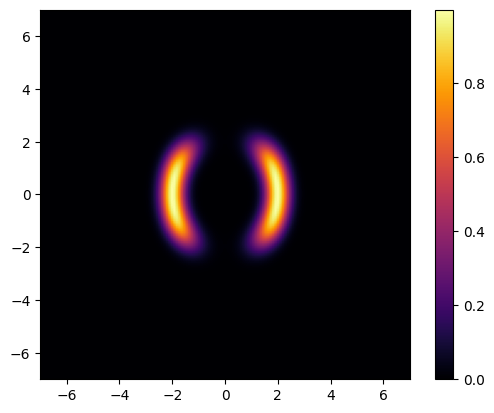

In [4]:
import torch, math
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib
import logging
logging.getLogger('matplotlib.font_manager').disabled = True # turns off warnings about fonts. 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #supress future warnings
import sys 
from pathlib import Path
# add our ./code/lr_experiment/ folder so we can find our config file 
sys.path.append(Path(".", "code", "lr_experiment").absolute().as_posix())
sys.path.append(Path(".", "code").absolute().as_posix())
from plotting_utils import plot_2D_potential, plot_2d_model_and_target
import seaborn as sns
# pretty palettes galore: https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f
virdis = sns.color_palette("viridis", as_cmap=True)
rocket = sns.color_palette("rocket", as_cmap=True) # flare extended to black/white at ends
mako = sns.color_palette("mako", as_cmap=True) # crest extended to black/white at ends
magma = sns.color_palette("magma", as_cmap=True)
inferno = sns.color_palette('inferno', as_cmap = True)


## define a target imporper density = potential
def pot_1(z):
    """Returns potential function (log of a probability up to a constant)

    Args: z (torch.array): of shape [num_rows, 2] (every row gives a point in the plane.)

    Returns:
        w (torch.array): of shape [num_rows] with potential values for each 2d point in z. 
    """
    z_1, z_2 = z[:, 0], z[:, 1]
    norm = torch.sqrt(z_1.pow(2) + z_2.pow(2))
    outer_term_1 = .5 * ((norm - 2) / .4) ** 2
    inner_term_1 = torch.exp((-.5 * ((z_1 - 2) / .6) ** 2))
    inner_term_2 = torch.exp((-.5 * ((z_1 + 2) / .6) ** 2))
    outer_term_2 = torch.log(inner_term_1 + inner_term_2 + 1e-7)
    u = outer_term_1 - outer_term_2
    return -u


# plot
plot_2D_potential(pot_1, min = -7, max = 7)

In [9]:
# setup everything needed for nf training:
z_size = 2
# hyperparameters for NF model: 
n_flows = 3

#instantiate model, optimizer, and list to store losses
model = NormalizingFlowSylvester(z_size, n_flows=n_flows) # number of layers/flows = n_flows

# hyperparameters for NF training (# from Rezende et al.)
learning_rate = 1e-3
momentum = .9
epochs = 2000 # will have 1 batch per epoch
batch_size = 200 # number of samples to use per batch = per epoch
lam = .1
# RMSprop is what they used in renzende et al
opt = torch.optim.RMSprop(
    params = model.parameters(),
    lr = learning_rate,
    momentum = momentum
)

from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(opt, 'min', patience=1000, verbose = True) 

losses = [] # to be populated
target_density = pot_1 # function that returns log(constant * probability density) 

/Users/robertbridges/ctrl-allt-dela/normalizing-flows-tutorial/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
for epoch in range(epochs):

    # samples = torch.autograd.Variable(random_normal_samples(batch_size)) # Variables is deprecated and i think this is unnecessary
    samples = random_normal_samples(batch_size, dim = z_size) # {u_i} sampled from base. 

    # compute  RKL loss function: 
    x, log_det_T = model(samples) # we need the log_det_T and the x_i = T(u_i) 
    log_p_x = target_density(x) # p*(x_i), needed for loss function
    loss = -(log_det_T + log_p_x).sum() # Reverse KL

    # take a step: 
    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")


Epoch 0, Loss 1256.0079345703125
Epoch 100, Loss 391.8883361816406
Epoch 200, Loss 333.5794677734375
Epoch 300, Loss 274.66571044921875
Epoch 400, Loss 253.60433959960938
Epoch 500, Loss 212.0970916748047
Epoch 600, Loss 299.30364990234375
Epoch 700, Loss 221.6396484375
Epoch 800, Loss 218.16339111328125
Epoch 900, Loss 248.10215759277344
Epoch 1000, Loss 235.23406982421875
Epoch 1100, Loss 239.8187255859375
Epoch 1200, Loss 217.5132293701172
Epoch 1300, Loss 253.24327087402344
Epoch 1400, Loss 224.97821044921875
Epoch 1500, Loss 197.21315002441406
Epoch 1600, Loss 246.3865966796875
Epoch 1700, Loss 215.7704315185547
Epoch 1800, Loss 233.36737060546875
Epoch 1900, Loss 278.4666748046875


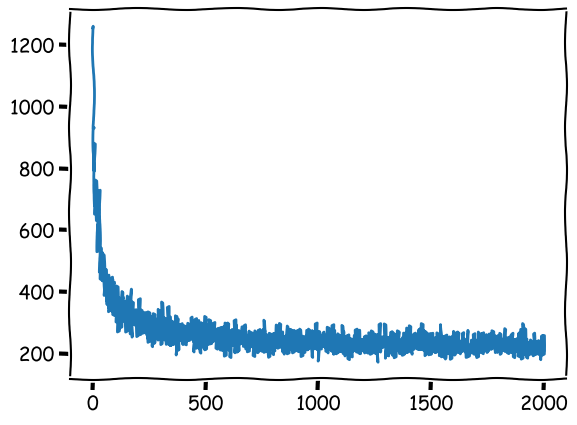

In [11]:
len(losses)
with plt.xkcd():
    plt.plot(range(len(losses)), losses)
    plt.show()
    


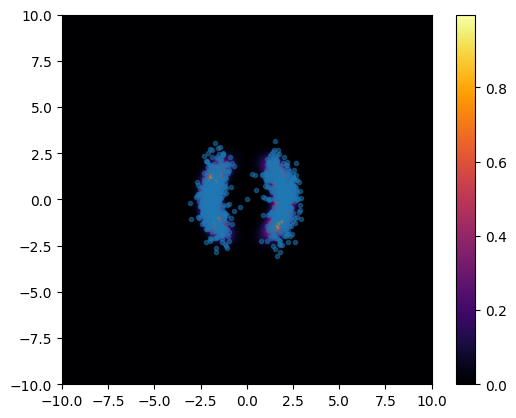

/Users/robertbridges/ctrl-allt-dela/normalizing-flows-tutorial/plotting_utils.py:184: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.figure.show()


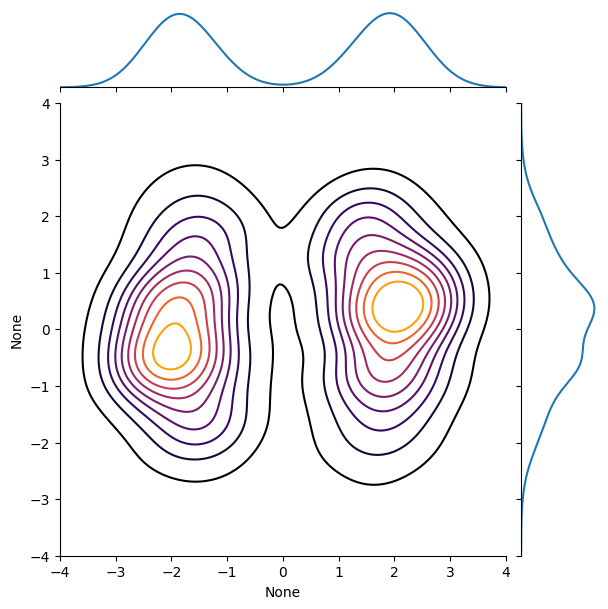

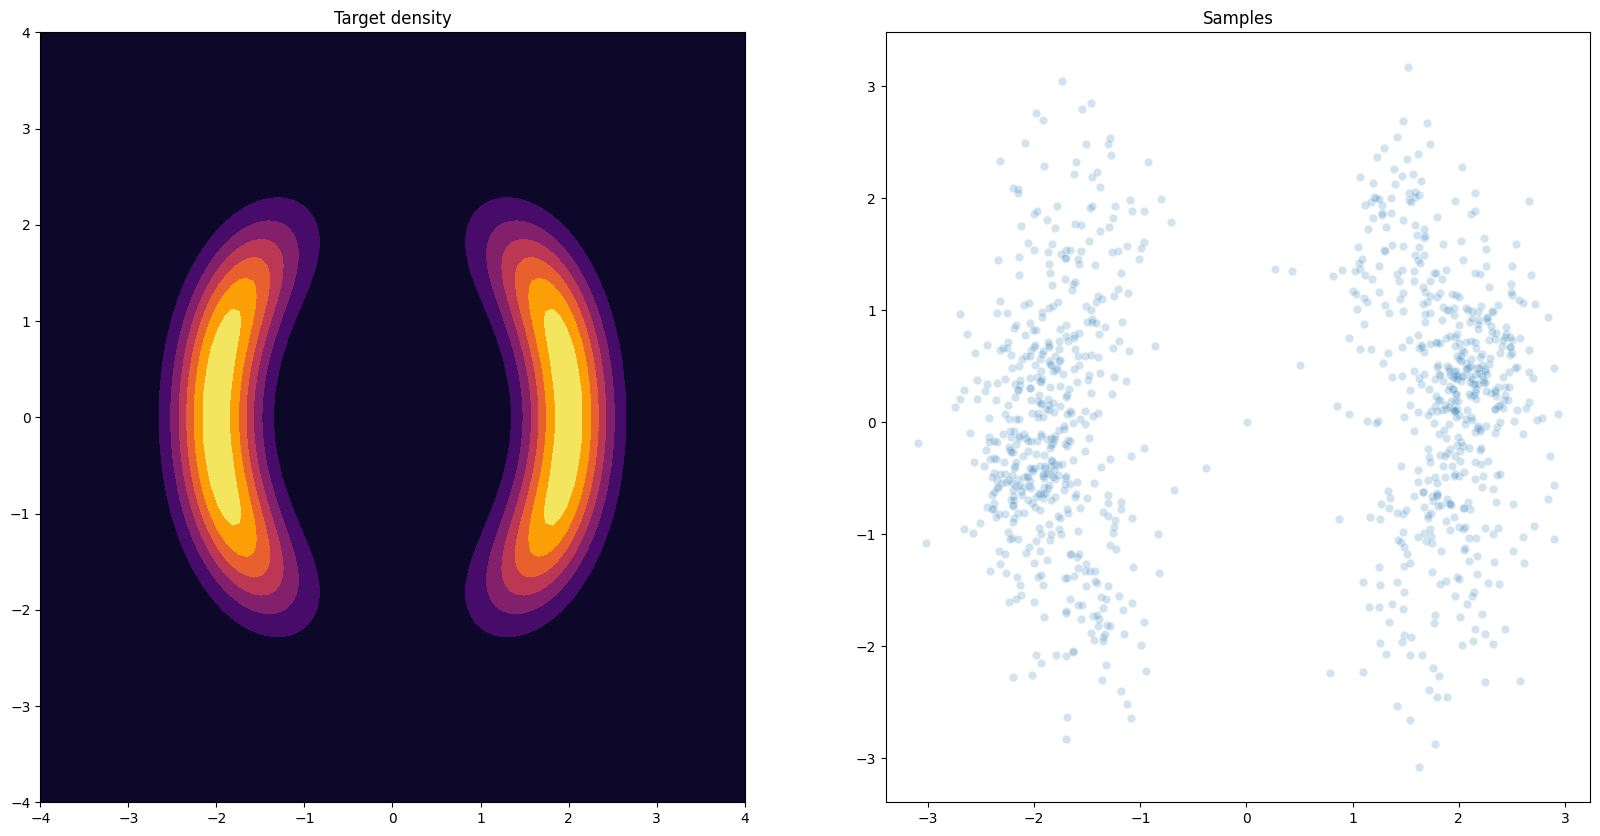

In [12]:
plot_2d_model_and_target(target_density, model, min = -10, max = 10, N = 1000)